# Exploratory notebook

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import urllib.parse
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
import explore_ms as e
import env

from io import BytesIO
from io import StringIO
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from IPython.display import display, display_html
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# ACQUIRE
- 

In [2]:
logs_df = e.get_sql_data()

In [3]:
logs_df.head().T

,0,1,2,3,4
lesson,/,java-ii,java-ii/object-oriented-programming,slides/object_oriented_programming,javascript-i/conditionals
user_id,1,1,1,1,2
cohort,Hampton,Hampton,Hampton,Hampton,Teddy
program_id,1,1,1,1,2
ip,97.105.19.61,97.105.19.61,97.105.19.61,97.105.19.61,97.105.19.61
start_date,2015-09-22,2015-09-22,2015-09-22,2015-09-22,2018-01-08
end_date,2016-02-06,2016-02-06,2016-02-06,2016-02-06,2018-05-17
program,web dev,web dev,web dev,web dev,web dev


In [4]:
logs_df.tail().T

,847325,847326,847327,847328,847329
lesson,jquery/personal-site,jquery/mapbox-api,jquery/ajax/weather-map,anomaly-detection/discrete-probabilistic-methods,jquery/mapbox-api
user_id,64,64,64,744,64
cohort,Staff,Staff,Staff,Staff,Staff
program_id,2,2,2,2,2
ip,71.150.217.33,71.150.217.33,71.150.217.33,24.160.137.86,71.150.217.33
start_date,2014-02-04,2014-02-04,2014-02-04,2014-02-04,2014-02-04
end_date,2014-02-04,2014-02-04,2014-02-04,2014-02-04,2014-02-04
program,web dev,web dev,web dev,web dev,web dev


In [5]:
logs_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847330 entries, 0 to 847329
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lesson      847329 non-null  object
 1   user_id     847330 non-null  int64 
 2   cohort      847330 non-null  object
 3   program_id  847330 non-null  int64 
 4   ip          847330 non-null  object
 5   start_date  847330 non-null  object
 6   end_date    847330 non-null  object
 7   program     847330 non-null  object
dtypes: int64(2), object(6)
memory usage: 51.7+ MB


In [6]:
logs_df.columns.tolist()


['lesson',
 'user_id',
 'cohort',
 'program_id',
 'ip',
 'start_date',
 'end_date',
 'program']

In [7]:
logs_df.shape

(847330, 8)

In [8]:
logs_df.describe()


,user_id,program_id
count,847330.000000,847330.000000
mean,456.707344,2.086004
std,250.734201,0.388231
min,1.000000,1.000000
25%,263.000000,2.000000
50%,476.000000,2.000000
75%,648.000000,2.000000
max,981.000000,4.000000


# PREPARE
- Coloumns were dropped in the acquire SQL query


In [9]:
logs_df.isnull().sum()


lesson        1
user_id       0
cohort        0
program_id    0
ip            0
start_date    0
end_date      0
program       0
dtype: int64

# 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [10]:
logs_df['lesson'].value_counts()

/                                                               45854
javascript-i                                                    18203
toc                                                             17591
search/search_index.json                                        17534
java-iii                                                        13166
                                                                ...  
content/examples/javascript/primitive-types.html                    1
content/examples/javascript/conditionals.html                       1
2-storytelling/1-overview/www.qlik.com                              1
syntax-types-and-variables                                          1
appendix/professional-development/post-interview-review-form        1
Name: lesson, Length: 2224, dtype: int64

In [11]:
logs_df['cohort'].value_counts().head()


Staff      84031
Ceres      40730
Zion       38096
Jupiter    37109
Fortuna    36902
Name: cohort, dtype: int64

In [12]:
logs_df['program'].value_counts().head()


web dev         743913
data science    103412
frontend             5
Name: program, dtype: int64

In [13]:
# Group the DataFrame by program_id, lesson, and name, and count the occurrences
grouped_traffic = logs_df.groupby(['program', 'lesson', 'cohort']) \
                    .size().reset_index(name='count')

# Sort the grouped DataFrame by count in descending order
top_lessons = grouped_traffic.sort_values('count', ascending=False)

# Filter the top lessons for program_id 1, excluding lessons like '/', 'appendix', 'index.html'
top_lessons_program_1 = top_lessons[
    (top_lessons['program'] == 1) &
    (~top_lessons['lesson'].isin(['/', 'appendix', 'index.html']))
].head(10)

In [14]:
logs_df

,lesson,user_id,cohort,program_id,ip,start_date,end_date,program
0,/,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06,web dev
1,java-ii,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06,web dev
2,java-ii/object-oriented-programming,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06,web dev
3,slides/object_oriented_programming,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06,web dev
4,javascript-i/conditionals,2,Teddy,2,97.105.19.61,2018-01-08,2018-05-17,web dev
...,...,...,...,...,...,...,...,...
847325,jquery/personal-site,64,Staff,2,71.150.217.33,2014-02-04,2014-02-04,web dev
847326,jquery/mapbox-api,64,Staff,2,71.150.217.33,2014-02-04,2014-02-04,web dev
847327,jquery/ajax/weather-map,64,Staff,2,71.150.217.33,2014-02-04,2014-02-04,web dev
847328,anomaly-detection/discrete-probabilistic-methods,744,Staff,2,24.160.137.86,2014-02-04,2014-02-04,web dev


### A function was created to identify the most trafficked lesson per Program accross Cohorts and these are the results 

In [ ]:
# # Define a function to get top lessons by program across cohorts
# def get_top_lessons_by_program(logs_df, program):
#     grouped_traffic = logs_df.groupby(['program', 'lesson', 'cohort']) \
#                         .size().reset_index(name='count')
#     top_lessons = grouped_traffic.sort_values('count', ascending=False)
    
#     # Filter for the specified program and remove unwanted lessons
#     program_top_lessons = top_lessons[
#         (top_lessons['program'] == program) &
#         (~top_lessons['lesson'].isin(['/', 'appendix', 'index.html']))
#     ]
    
#     # Get the top lesson across cohorts for the program
#     top_lesson_across_cohorts = program_top_lessons.groupby('lesson')['count'].size().idxmax()
    
#     return program_top_lessons.head(10), top_lesson_across_cohorts

In [15]:
# Call the function to get top lessons for web dev and cohorts
top_lessons_program_wd, top_lesson_across_cohorts_wd = e.get_top_lessons_by_program(logs_df, program='web dev')
"Top Lessons for Program web development:"
top_lessons_program_wd

print("Top Lesson Across Cohorts for Program Web Development:")
print(top_lesson_across_cohorts_wd)

Top Lesson Across Cohorts for Program Web Development:
html-css


In [16]:
# Call the function to get top lessons for data science across cohorts
top_lessons_program_ds, top_lesson_across_cohorts_ds =e. get_top_lessons_by_program(logs_df, program='data science')
"Top Lessons for Program data science:"
top_lessons_program_ds

print("Top Lesson Across Cohorts for Program Data  Science:")
print(top_lesson_across_cohorts_ds)

Top Lesson Across Cohorts for Program Data  Science:
1-fundamentals/1.1-intro-to-data-science


In [17]:
# Call the function to get top lessons for data science across cohorts
top_lessons_program_fe, top_lesson_across_cohorts_fe = e.get_top_lessons_by_program(logs_df, program='frontend')
"Top Lessons for Program Frontend:"
top_lessons_program_fe

print("Top Lesson Across Cohorts for Program Front-end")
print(top_lesson_across_cohorts_fe)

Top Lesson Across Cohorts for Program Front-end
content/html-css


In [18]:
top_lesson_across_cohorts_ds

'1-fundamentals/1.1-intro-to-data-science'

# 7. Which lessons are least accessed?


In [ ]:
# Call the function to get top lessons for web dev and cohorts
least_lessons_program_wd, least_lesson_across_cohorts_wd = get_least_accessed_lessons(logs_df, program='web dev')
"Least Accessed Lessons for Program web development:"
least_lessons_program_wd

print("Least Accessed Lessons Across Cohorts for Program Web Development:")
print(least_lesson_across_cohorts_wd)

In [ ]:
 #Call the function to get top lessons for web dev and cohorts
least_lessons_program_ds, top_lesson_across_cohorts_ds = get_least_accessed_lessons(logs_df, program='data science')
"Least Accessed Lessons for Program Web Development:"
least_lessons_program_wd

print("Least Accessed Across Cohorts for Program Data Science:")
print(least_lesson_across_cohorts_ds)

In [ ]:
#Call the function to get top lessons for web dev and cohorts
top_lessons_program_wd, top_lesson_across_cohorts_wd = get_least_accessed_lessons(logs_df, program='web dev')
"Least Accessed Lessons for Program web development:"
least_lessons_program_wd

print("Least Accessed Lessons Across Cohorts for Program Web Development:")
print(least_lesson_across_cohorts_wd)

In [21]:
# Define a function to get least frequented lessons 

def get_least_accessed_lessons(logs_df, program):
    grouped_traffic = logs_df.groupby(['program', 'lesson', 'cohort']) \
                        .size().reset_index(name='count')
    least_accessed_lessons = grouped_traffic.sort_values('count', ascending=True)
    
    # Filter for the specified program and remove unwanted lessons
    program_least_accessed_lessons = least_accessed_lessons[
        (least_accessed_lessons['program'] == program) &
        (~least_accessed_lessons['lesson'].isin(['/', 'appendix', 'index.html']))
    ]
    
    # Get the least accessed lesson across cohorts for the program
    least_accessed_lesson_across_cohorts = program_least_accessed_lessons.groupby('lesson')['count'].size().idmax()
    
    return program_least_accessed_lessons.head(10), least_accessed_lesson_across_cohorts

In [22]:
least_accessed_lesson_across_cohorts_ds

NameError: name 'least_accessed_lesson_across_cohorts_ds' is not defined

In [23]:
# Call the function to get least accessed lessons for Data Science and Frontend programs
least_accessed_lessons_ds, least_accessed_lesson_across_cohorts_ds = get_least_accessed_lessons(logs_df, program='data science')
least_accessed_lessons_fe, least_accessed_lesson_across_cohorts_fe = get_least_accessed_lessons(logs_df, program='frontend')

AttributeError: 'Series' object has no attribute 'idmin'

# EXPLORE 

AttributeError: 'str' object has no attribute 'values'

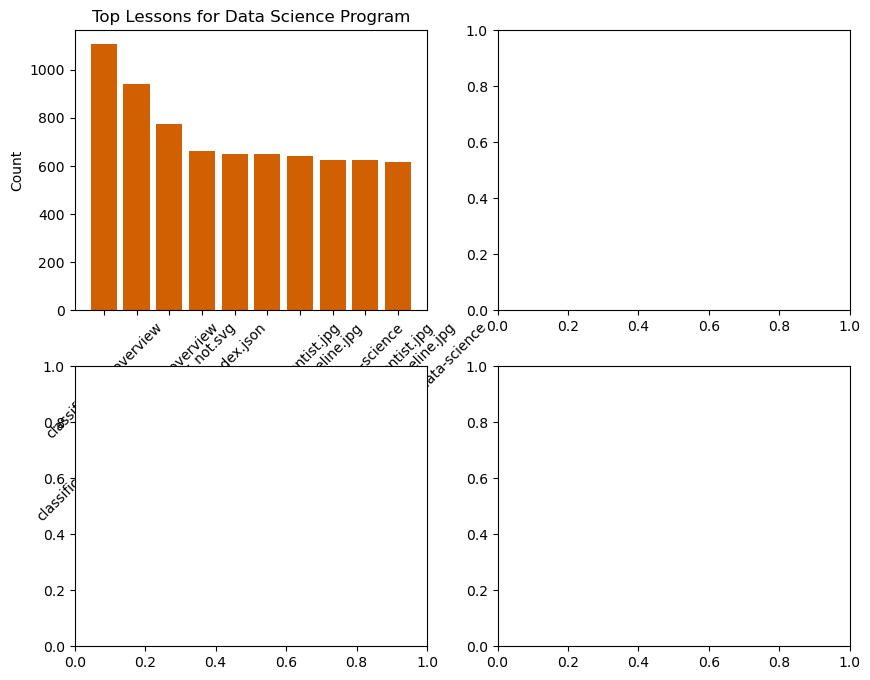

In [25]:
# Define the color palette
color_palette = ['#D16002', '#EC9706', '#7A3803']

# Call the function to get top lessons for Data Science and Frontend programs
top_lessons_program_ds, top_lesson_across_cohorts_ds = e.get_top_lessons_by_program(logs_df, program='data science')
top_lessons_program_fe, top_lesson_across_cohorts_fe = e.get_top_lessons_by_program(logs_df, program='frontend')

# Create subplots for the histograms
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot histograms for Data Science program
axes[0, 0].bar(top_lessons_program_ds['lesson'], top_lessons_program_ds['count'], color=color_palette[0])
axes[0, 0].set_title('Top Lessons for Data Science Program')
axes[0, 0].set_xlabel('Lesson')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(top_lesson_across_cohorts_ds.index, top_lesson_across_cohorts_ds.values, color=color_palette[1])
axes[0, 1].set_title('Distribution of Top Lesson Across Cohorts for Data Science Program')
axes[0, 1].set_xlabel('Lesson')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot histograms for Frontend program
axes[1, 0].bar(top_lessons_program_fe['lesson'], top_lessons_program_fe['count'], color=color_palette[2])
axes[1, 0].set_title('Top Lessons for Frontend Program')
axes[1, 0].set_xlabel('Lesson')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(top_lesson_across_cohorts_fe.index, top_lesson_across_cohorts_fe.values, color=color_palette[0])
axes[1, 1].set_title('Distribution of Top Lesson Across Cohorts for Frontend Program')
axes[1, 1].set_xlabel('Lesson')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
